# Working on Data in Jupyter Lab
-----

Something new for me

## Task 1 - Import your data

### Students

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
try:
    local_stopwords = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    local_stopwords = stopwords.words('english')

In [2]:
studentdf = pd.read_csv("../Data/StudentsPerformance.csv")

### Spam

In [3]:
spamdf = pd.read_csv("../Data/spam.csv", encoding='cp1252') ## Had to change encoding

Reducing the extra 3 columns to the one, second variable column - messages now complete

In [4]:
spamdf.fillna('', inplace=True)
spamdf.v2 = spamdf.v2 + spamdf.iloc[:, 2] + spamdf.iloc[:, 3] + spamdf.iloc[:, 4]
spamdf.drop(spamdf.columns[2:], axis=1, inplace=True)

### Retail Sales

In [5]:
retaildf = pd.read_csv("../Data/Online Retail.csv", index_col="InvoiceNo")
retaildf

,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
InvoiceNo,,,,,,,
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2011 12:50,0.85,12680.0,France
581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2011 12:50,2.10,12680.0,France
581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2011 12:50,4.15,12680.0,France


> Removing Rows with no CustomerID attached then converting to int 

In [6]:
retaildf = retaildf[retaildf.CustomerID.notna()]
retaildf.loc[:,"CustomerID"] = retaildf.CustomerID.astype(int)

> Drop zero-value unit quantity and sub-0.01 unit price

In [7]:
retaildf = retaildf[retaildf.UnitPrice >= 0.01]
retaildf = retaildf[retaildf.Quantity != 0]

> Some Quantity values are negative - return absolute values

<Axes: >

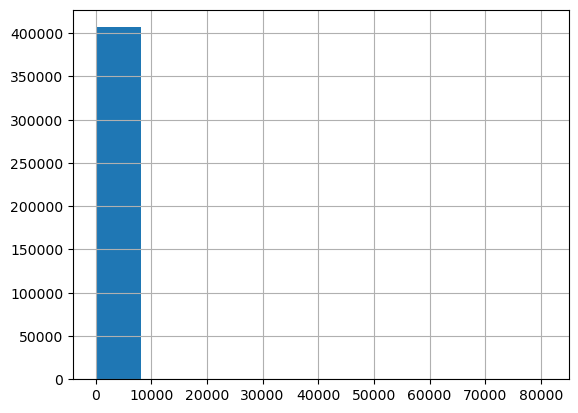

In [8]:
retaildf.Quantity = retaildf.Quantity.abs()
retaildf.Quantity.hist()

> I don't like that there are some codes with letters and numbers :/

In [9]:
retaildf.StockCode = retaildf.StockCode.str.replace(r'\D*?(\d*)\D?',
                                                    repl= lambda x: x.group(1),
                                                    regex=True)

> Add column aggregating UnitPrice and Quantity

In [10]:
retaildf["ItemPrice"] = retaildf.UnitPrice * retaildf.Quantity

In [11]:
retaildf.InvoiceDate = pd.to_datetime(retaildf.InvoiceDate, format="mixed")
retaildf = retaildf.assign(Date=retaildf.InvoiceDate.dt.date,
                Time=retaildf.InvoiceDate.dt.time)

> Literally just grouping by interesting variable

<Axes: xlabel='Date'>

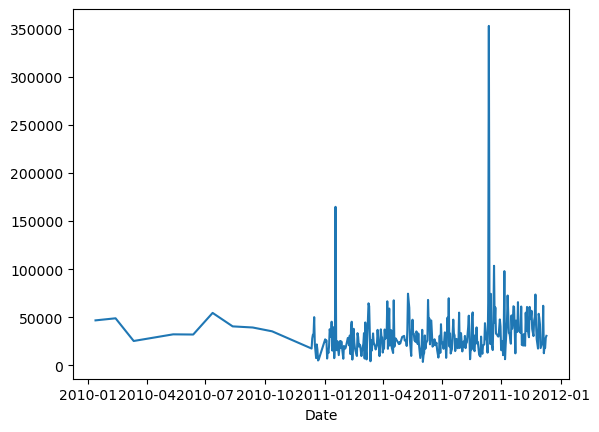

In [12]:
groupbyInvoiceNo = retaildf.groupby("InvoiceNo")
groupbyCountry = retaildf.groupby("Country")
groupbyStockCode = retaildf.groupby("StockCode")
groupbyDate = retaildf.groupby("Date")
groupbyDate.ItemPrice.sum().plot()

> Now that I've got a dataframe for the invoices, I can do measures of similarity based on the items, I think?

In [13]:
invoiceItems = pd.crosstab(retaildf.index, retaildf.StockCode)

In [14]:
similarities = cosine_similarity(invoiceItems,
                                 dense_output=False)

In [15]:
sim_values = similarities[np.triu_indices(similarities.shape[0], k=1)]# Upper triangle, excluding diagonal
#sim_values = sim_values[sim_values > 0.5]

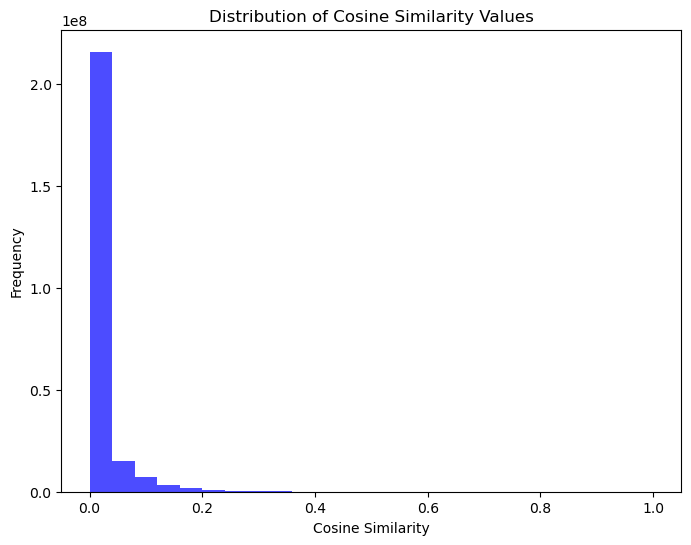

In [16]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(sim_values, bins=25, color="blue", alpha=0.7)
plt.title("Distribution of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [17]:
# Determine the most common words in the description column
# Remove split at Special Characters
value_counts = retaildf.Description.str.lower().str.split(r"[\ +/,-]").explode().value_counts()

# Remove stopwords, number values and other characters like " ' and &
value_counts = value_counts[~(value_counts.index.str.lower().isin(local_stopwords + ['set']))]
value_counts = value_counts[~(value_counts.index.str.lower().str.contains(r'^\d+|^\d*$|[&"\']', regex=True))]

In [18]:
%%timeit -r 1
terms = value_counts.nlargest(50).index.to_list() # - Creates df with 50 features
#terms = value_counts.index.str.upper().to_list() # - Creates df with many features
terms.sort()

vocabulary = pd.DataFrame({'term': terms})
vocabulary = vocabulary.set_index('term')

for term in terms:
    vocabulary.loc[term, 'docs'] = retaildf[retaildf.Description.str.contains(re.escape(term.upper()))].index.unique().to_list()
for term in terms:
    vocabulary.loc[term, 'counts'] = len(vocabulary.loc[term].docs)

vocabulary.counts = vocabulary.counts.astype(int)

12.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


> Bit slow, I think I'd like to find a way to speed this up